# FoReS (Foundation Recommender System)
A recommender system for people that are new to the world of foundations and don't know where to start. Basically it recommends you a foundation shades based on your skin tone using Fitzpatrick scale.

In [1]:
%pip install torch torchvision

Note: you may need to restart the kernel to use updated packages.


## Import the necessary package

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry
from PIL import Image
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [3]:
using_colab = False

In [4]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib torch torchvision
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

In [5]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

## Data Exploration Analysis

In [6]:
# Count the number of train and val images
train_data = pd.read_csv('datasets/fitzpatrick/train.csv')
test_data = pd.read_csv('datasets/fitzpatrick/test.csv')
train_images = len(os.listdir("datasets/fitzpatrick/fairface/train/"))
test_images = len(os.listdir("datasets/fitzpatrick/fairface/val/"))

print(f"Train data: {len(train_data)}")
print(f"Test data: {len(test_data)}")
print(f"Train images: {train_images}")
print(f"Test images: {test_images}")

Train data: 35424
Test data: 4515
Train images: 35445
Test images: 4535


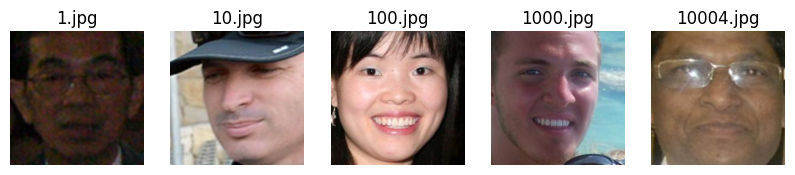

In [7]:
# Display 5 images from train folder
plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    image = cv2.imread(f"datasets/fitzpatrick/fairface/train/{train_data.iloc[i]['file']}")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(train_data.iloc[i]['file'].split('/')[0])
    plt.axis('off')
plt.show()

## Images Preprocessing

### Image Segmentation

In [8]:
df_train = pd.read_csv('datasets/fitzpatrick/train.csv')
df_test = pd.read_csv('datasets/fitzpatrick/test.csv')

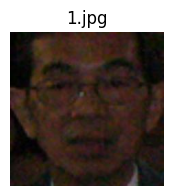

In [9]:
# Read all the images from the train.csv file
file_paths_train = df_train['file'].apply(lambda x: f"datasets/fitzpatrick/fairface/train/{x}").values
train_images = np.array([cv2.imread(file_path) for file_path in file_paths_train])

plt.figure(figsize=(2, 2))
plt.imshow(cv2.cvtColor(train_images[0], cv2.COLOR_BGR2RGB))
plt.title(df_train.iloc[0]['file'].split('/')[0])
plt.axis('off')
plt.show()

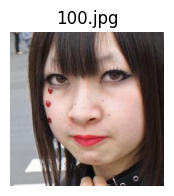

In [11]:
# Read all the images from the test.csv file
file_paths_test = df_test['file'].apply(lambda x: f"datasets/fitzpatrick/fairface/val/{x}").values
test_images = np.array([cv2.imread(file_path) for file_path in file_paths_test])

plt.figure(figsize=(2, 2))
plt.imshow(cv2.cvtColor(test_images[0], cv2.COLOR_BGR2RGB))
plt.title(df_test.iloc[0]['file'].split('/')[0])
plt.axis('off')
plt.show()

In [12]:
# img = cv2.imread("datasets/fitzpatrick/fairface/train/15.jpg")
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# From the code above, try to read all the train_images and test_images
converted_train_images = np.array([cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in train_images])

### Attention

Adjust your model name depending on the checkpoint you use
- **`default`** or **`vit_h`**: [ViT-H SAM model.](https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth)
- `vit_l`: [ViT-L SAM model.](https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth)
- `vit_b`: [ViT-B SAM model.](https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth)

In [ ]:
device = "cuda"
model_name = "vit_l" # adjust your model name
model_checkpoint = "model_checkpoints/sam_vit_l_0b3195.pth" # your model checkpoint path
sam = sam_model_registry[model_name](checkpoint=model_checkpoint)
if using_colab:
    sam.to(device=device)
mask_gen = SamAutomaticMaskGenerator(sam)
# masks = mask_gen.generate(img)
masks = np.array([mask_gen.generate(img) for img in converted_train_images])

In [12]:
print(f"Mask Length: {len(masks)}")
print(masks[0].keys())
# print(masks[0].get("segmentation"))
print(masks[1].get("area"))
# print(masks[0].get("bbox"))
# print(masks[0].get("predicted_iou"))
# print(masks[0].get("point_coords"))
# print(masks[0].get("stability_score"))
# print(masks[0].get("crop_box"))

Mask Length: 13
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])
2295


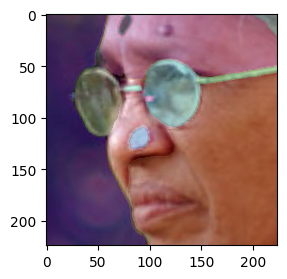

In [13]:
plt.figure(figsize=(3, 3))
plt.imshow(img)
show_anns(masks)
plt.show()

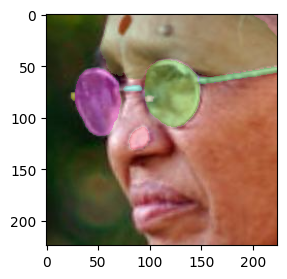

In [14]:
# Get the face masks
face_masks = [mask for mask in masks if mask.get("area") < 10000]
# Show the face masks on the image
plt.figure(figsize=(3, 3))
plt.imshow(img)
show_anns(face_masks)
plt.show()

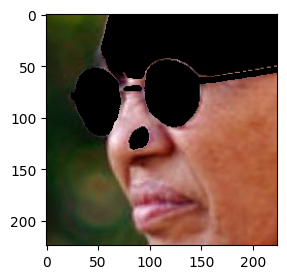

In [15]:
# Remove the selected face_masks from the image
for mask in face_masks:
    img[mask.get("segmentation")] = [0, 0, 0]
plt.figure(figsize=(3, 3))
plt.imshow(img)
plt.show()